# NLP for Classification of Tweets During Crisis-Events


## Problem Description

Collecting and analyzing data quickly is of utmost importance during crisis situations such as natural disasters and human conflicts. Social media has become an increasingly important source of information, often outpacing traditional media outlets. However, a key challenge in analyzing disaster-related information on social media is recognizing which posts could be relevant for relief  efforts.
In this project, we propose analyzing crises through the lense of twitter, and building a classifier which will select posts containing relevant information for disaster-management [[1]](https://elib.dlr.de/137213/1/2278_MattiWiegmann_etal2020.pdf) [[2]](https://nhess.copernicus.org/articles/21/1825/2021/).

Specifically, we will address the following questions:

**Model effectiveness in real-time disasters of the same type**: How well can a model trained on one type of disaster (i.e floods, shootings, etc.) perform on similar events of the same type? What amount of data will be needed to train a successful event-specific network?

**Model effectiveness in real-time disasters of different types**: Can information be transferred between different types of disasters. That is, can a model trained on data pertaining to certain types of disasters perform well on tweets relating to a different disaster?


## Data Set



The raw data consists of 250,000 tweets in a multitude of languages related to 26 different crises. All of the crises occurred in 2012 or 2013 and includes, for example, the Boston bombings, Austrailian wildfires and LA Airport shootings. Out of the 250,000 tweets in the data set about 28,000 are labeled with information source, information type and informativeness. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import re

Reading the data:

In [25]:
#with open(fullpath) as f:
#    json.loads(f.read())
    #data = json.load(f)
#tmp_json = pd.json_normalize(data)
json.loads(fullpath)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [26]:
ncrisis = -1
df_total = []
for dirname, _, filenames in os.walk(".\\CrisisLexT26-v1.0\\CrisisLexT26"):
    df =  []
    tmp_csv = []
    tmp_json = []
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        try:
            if fullpath.endswith('_labeled.csv'):
                # read_csv
                tmp_csv = pd.read_csv(fullpath)#, index_col=0).reset_index()
            elif fullpath.endswith('.json'):
                # read_json
                with open(fullpath) as f:
                    data = json.load(f)
                tmp_json = pd.json_normalize(data)
        except:
            print(fullpath)
            print('Exception error')
            break
    if len(tmp_csv) >1:
        ncrisis  += 1
        tmp_json = pd.DataFrame(np.repeat(tmp_json.values, len(tmp_csv), axis=0), columns=tmp_json.columns)
        df = pd.concat([tmp_json, tmp_csv], axis=1)
        if ncrisis  == 0: 
            df_total = df 
        else:
             df_total = pd.concat([df_total, df], axis=0)
    #if ncrisis  == 2:
    #    break

In [27]:
formatted_columns = [col.lower().replace(" ", "").replace(".", "_") for col in df_total.columns]
df_total = pd.DataFrame(df_total.values, columns=formatted_columns)
df_total.columns

Index(['name', 'external_url', 'keywords', 'size_kw_collection',
       'size_geo_collection', 'time_development', 'time_duration', 'time_year',
       'time_month', 'time_start_day', 'location_country', 'location_spread',
       'location_location_description',
       'location_country_internet_penetration', 'categorization_category',
       'categorization_sub_category', 'categorization_type', 'tweetid',
       'tweettext', 'informationsource', 'informationtype', 'informativeness'],
      dtype='object')

In [28]:
df_total.head(3)

,name,external_url,keywords,size_kw_collection,size_geo_collection,time_development,time_duration,time_year,time_month,time_start_day,...,location_location_description,location_country_internet_penetration,categorization_category,categorization_sub_category,categorization_type,tweetid,tweettext,informationsource,informationtype,informativeness
0,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related
1,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related
2,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related


# Preprocessing the tweets

- replacement of all 
URLs with `<URL>`, hashtags with `<HASHTAG>`, user mentions with `<USER>`, emoticons with `<EMOTICON>` and emojis with `<EMOJI>`

In [29]:
def replace_url(text):
    url_pattern = r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*'
    tweets = re.sub(url_pattern ,'<URL>', text)
    return tweets

def replace_hashtag(text):
    hashtag_pattern = r'#'
    tweets = re.sub(hashtag_pattern, '<HASHTAG>', text)
    return tweets

def replace_user(text):
    user_pattern = r'@\S+'
    tweets = re.sub(user_pattern, '<USER>', text)
    return tweets

def replace_emoticons(text):
    emoticon_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" # emoticons
                                   "]+", flags=re.UNICODE)
    return emoticon_pattern.sub(r'<EMOTICON>',text)



def replace_emoji(text):
    emoji_pattern = re.compile("["                               
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'<EMOJI>', text)

In [30]:
df_total['tweettext'] = df_total['tweettext'].str.lower() # convert to lowercase
df_total['tweettext'] = df_total['tweettext'].apply(lambda text: replace_url(text)) # replacement of all URLs with <URL>
df_total['tweettext'] = df_total['tweettext'].apply(lambda text: replace_hashtag(text))
df_total['tweettext'] = df_total['tweettext'].apply(lambda text: replace_user(text))
df_total['tweettext'] = df_total['tweettext'].apply(lambda text: replace_emoticons(text))
df_total['tweettext'] = df_total['tweettext'].apply(lambda text: replace_emoji(text))
df_total.drop_duplicates(subset=['tweettext'], keep='last')
df_total['tweettext'].head()

0    <HASHTAG>intern <HASHTAG>us <HASHTAG>tattoo <H...
1    rt <USER> get in on the fun every thursday wit...
2    welcome to our newest studentathlete- reagan b...
3    denver post: <HASHTAG>colorado governor signs ...
4    pretty sure i'm going to live in manitou sprin...
Name: tweettext, dtype: object

In [31]:
df_total['cat_informativeness'] = df_total['informativeness'] 
df_total.loc[df_total.cat_informativeness != 'Related and informative','cat_informativeness'] = 'Not related'

In [32]:
df_total.groupby(['name', 'time_year', 'location_country', 'cat_informativeness']).agg({'tweettext':'count'})

tweettext
name                         time_year location_country cat_informativeness               
Alberta Floods               2013      Canada           Not related                    315
                                                        Related and informative        685
Australia wildfires          2013      Australia        Not related                    495
                                                        Related and informative        704
Bohol earthquake             2013      Phillipines      Not related                    575
                                                        Related and informative        425
Boston Bombings              2013      US               Not related                    583
                                                        Related and informative        417
Brazil nightclub fire        2013      Brazil           Not related                    558
                                                        Related and informative        442
Colorado Floods              2013      US               Not related                    232
                                                        Related and informative        768
Colorado wildfires           2012      US               Not related                    515
                                                        Related and informative        685
Costa Rica earthquake        2012      Costa Rica       Not related                    670
                                                        Related and informative        742
Glasgow helicopter crash     2013      UK               Not related                    522
                                                        Related and informative        578
Guatemala earthquake         2012      Guatemala        Not related                    296
                                                        Related and informative        754
Italy earthquakes            2012      Italy            Not related                    373
                                                        Related and informative        627
LA Airport Shootings         2013      US               Not related                    350
                                                        Related and informative        682
Lac-Megantic train crash     2013      Canada           Not related                    441
                                                        Related and informative        559
Manila Floods                2013      Phillipines      Not related                    372
                                                        Related and informative        628
NYC train crash              2013      US               Not related                     96
                                                        Related and informative        904
Philipinnes Floods           2012      Philipinnes      Not related                    239
                                                        Related and informative        761
Queensland Floods            2013      Australia        Not related                    472
                                                        Related and informative        728
Sardinia Floods              2013      Italy            Not related                    369
                                                        Related and informative        631
Savar building collapse      2013      Bangladesh       Not related                    414
                                                        Related and informative        836
Singapore Haze               2013      Singapore        Not related                    539
                                                        Related and informative        461
Spain train crash            2013      Spain            Not related                    271
                                                        Related and informative        729
Typhoon Pablo                2012      Phillipines      Not related          

In [35]:
df_total.groupby(['categorization_type', 'cat_informativeness']).agg({'tweettext':'count'})

tweettext
categorization_type cat_informativeness               
Bombings            Not related                    583
                    Related and informative        417
Collapse            Not related                    414
                    Related and informative        836
Crash               Not related                    522
                    Related and informative        578
Derailment          Not related                    808
                    Related and informative       2192
Earthquake          Not related                   1914
                    Related and informative       2548
Explosion           Not related                    982
                    Related and informative       1018
Fire                Not related                    558
                    Related and informative        442
Floods              Not related                   1999
                    Related and informative       4201
Haze                Not related                    539
                    Related and informative        461
Shootings           Not related                    350
                    Related and informative        682
Typhoon             Not related                    605
                    Related and informative       1443
Wildfire            Not related                   1010
                    Related and informative       1389

### Exploratory Data Analsis

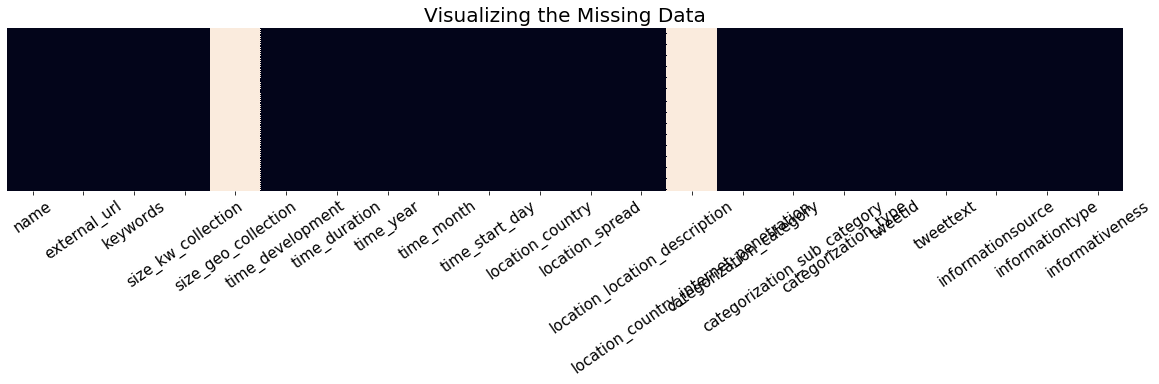

In [32]:
plt.figure(figsize = (20, 3))
sns.heatmap(df_total.isna(), yticklabels = False, cbar = False)
plt.title("Visualizing the Missing Data", fontsize = 20)
plt.xticks(rotation = 35, fontsize = 15)
plt.show()

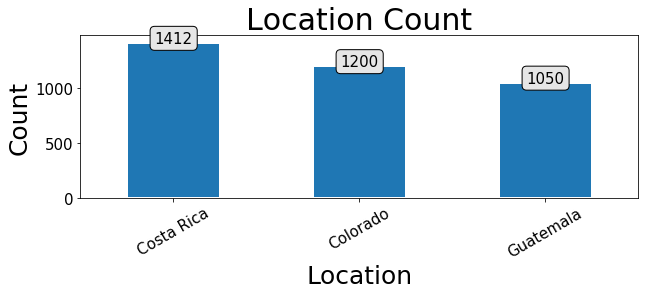

In [34]:
plt.figure(figsize = (10, 3))
ax = plt.axes()
ax = ((df_total['location_location_description'].value_counts())[:10]).plot(kind = 'bar',  linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 30)
plt.xlabel('Location', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
ax.xaxis.set_tick_params(labelsize = 15, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height() + 2),
                   bbox = bbox_args,
                   fontsize = 15)

## Baseline Model: Filtering by characteristics

As a baseline approach we will use filtering by characteristics. The filtering by characteristics classifies the twitters searching for tweets with specific hashtags, keywords or location [[1]](https://elib.dlr.de/137213/1/2278_MattiWiegmann_etal2020.pdf). For this we will use the lexicon Crisis Lex, which is a list of more than 300 lexicons related to disasters [[7]](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8091/8138).

In [12]:
# fullpath= os.path.join(dirname, filename)

for dirname, _, filenames in os.walk(".\\CrisisLexLexicon"):
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        if fullpath.endswith('.txt'):
            list_crisislex = open(fullpath,'r').read().splitlines()
            break
               

In [48]:
def baseline_model(list_crisislex, df_total):
    pattern = '|'.join(list_crisislex) 
    y_pred = df_total['tweettext'].str.contains(pattern)
    return y_pred
y_pred = baseline_model(list_crisislex, df_total)

In [54]:
y_actual  = np.where(df_total.cat_informativeness =='Related and informative', True, False)

array([False, False, False, ..., False,  True,  True])

Confusion Matrix

[[1308  173]
 [1619  562]]

Accuracy: 0.51

Precision: 0.76
Micro: 0.26
F1-score: 0.39


Classification Report

                         precision    recall  f1-score   support

            Non related       0.45      0.88      0.59      1481
Related and informative       0.76      0.26      0.39      2181

               accuracy                           0.51      3662
              macro avg       0.61      0.57      0.49      3662
           weighted avg       0.64      0.51      0.47      3662



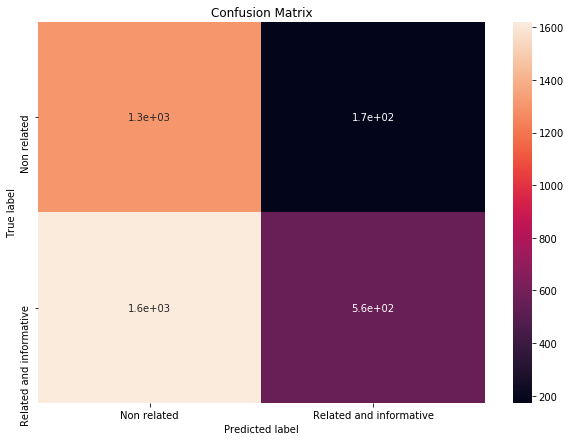

In [77]:
def evaluate(y_test, y_pred):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
    labels = ['Non related', 'Related and informative']
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)

    df_cm = pd.DataFrame(confusion, index=[i for i in labels],
                         columns=[i for i in labels])

    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True)
    plt.title('Confusion Matrix')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # importing accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    print('\nAccuracy: {:.2f}\n'.format(accuracy))

    precision = precision_score(y_test, y_pred)
    print('Precision: {:.2f}'.format(precision))

    recall = recall_score(y_test, y_pred)
    print('Micro: {:.2f}'.format(recall))

    f1score = f1_score(y_test, y_pred)
    print('F1-score: {:.2f}\n'.format(f1score))
    


    print('\nClassification Report\n')
    report = classification_report(y_test, y_pred, target_names = labels)
    print(report)
    return accuracy, precision, recall, f1score 
accuracy, precision, recall, f1score = evaluate(y_actual, y_pred)

The basedline-filtering approach easily misses tweets that do not mention the keywords specified in advance, particularly when changes occur or the attention focus shifts during the event. 